In [1]:
import glob
import matplotlib
import matplotlib.pyplot as plt
import pickle
import lmfit
import numpy as np
import scipy.stats as ss
plt.style.use('neuron_color')
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.formula.api import ols, rlm
import sys
sys.path.append('../')
from Linearity import Neuron
from pickle import dump

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
#Colorscheme for squares
color_sqr = { index+1: color for index, color in enumerate(matplotlib.cm.viridis(np.linspace(0,1,9)))}
currentClampFiles = '/media/sahil/NCBS_Shares_BGStim/patch_data/current_clamp_files_with_GABAzine.txt'
with open (currentClampFiles,'r') as r:
    dirnames = r.read().splitlines()
neurons = {}
for dirname in dirnames:
    cellIndex = dirname.split('/')[-2]
    filename = dirname + 'plots/' + cellIndex + '.pkl'
    n = Neuron.load(filename)
    neurons[str(n.date) + '_' + str(n.index)] = n
control_result2_rsquared_adj = []
control_result1_rsquared_adj = []
control_var_expected = []
gabazine_result2_rsquared_adj = []
gabazine_result1_rsquared_adj = []
gabazine_var_expected = []
tolerance = 5e-4

In [4]:
def simpleaxis(axes, every=False, outward=False):
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if (outward):
            ax.spines['bottom'].set_position(('outward', 10))
            ax.spines['left'].set_position(('outward', 10))
        if every:
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_title('')
def linearModel(x, beta=1):
    # Linear model
    return (beta*x)

def DN_model(x, beta=1, gamma=100):
    # Divisive normalization model
    #return x - a*(x**2)/(b+x)
    #return ((x**2)*(1-beta) + (gamma*x))/(x+gamma)
    return (gamma*x)/(x+gamma)

In [5]:
neurons.keys()

['160928_c4',
 '160817_c4',
 '161117_c1',
 '170222_c2',
 '161228_c1',
 '160830_c1',
 '161027_c3',
 '160920_c1',
 '161013_c1',
 '160927_c5',
 '170303_c1']

In [189]:
lin_aic = []
dn_aic = []
lin_chi = []
dn_chi = []

control_observed = {}
control_observed_average = {}
gabazine_observed ={}
gabazine_observed_average = {}
control_expected = {}
control_expected_average = {}
gabazine_expected ={}
gabazine_expected_average = {}
feature = 0

neuron = neurons['170303_c1']
# neuron = neurons['170303_c1']
## 5 A (GABAzine treatment abolishes divisive normalization)
feature = 0
expected, observed, g_expected, g_observed = {}, {}, {}, {}
for expType, exp in neuron:
    ## Control case
    if expType == "Control":
        for sqr in exp:
            if sqr in [1,2]:
                for coord in exp[sqr].coordwise:
                    observed[coord] = []
                    for trial in exp[sqr].coordwise[coord].trials:
                        if all([value == 0 for value in trial.flags.values()]):
                            #expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
                            observed[coord].append(trial.feature[feature])
                    if len(observed[coord]) <3:
                        observed.pop(coord)
    ## Gabazine case
    if(expType == "GABAzine"):
        for sqr in exp:
            if sqr in [1,2]:
                for coord in exp[sqr].coordwise:
                    g_observed[coord] = []
                    for trial in exp[sqr].coordwise[coord].trials:
                        if all([value == 0 for value in trial.flags.values()]):
                            #g_expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
                            g_observed[coord].append(trial.feature[feature])
                    if len(g_observed[coord]) <3:
                        g_observed.pop(coord)

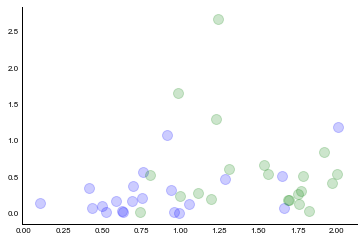

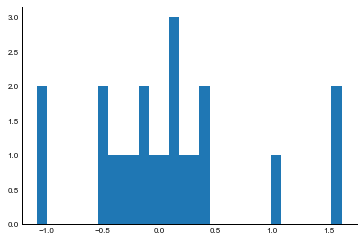

[[ 1.         -0.12322167]
 [-0.12322167  1.        ]]
[[1.         0.06713352]
 [0.06713352 1.        ]]
[[ 1.         -0.07755516]
 [-0.07755516  1.        ]]


In [193]:
max_weight = 2. # mV
g_mean, g_var, o_mean, o_var, num_sqr = [], [], [], [], []
for coord in list(set(observed)&set(g_observed)):
    o_m, o_v = np.mean(observed[coord]), np.var(observed[coord], ddof=1)
    g_m, g_v = np.mean(g_observed[coord]), np.var(g_observed[coord], ddof=1)
    if g_m < max_weight:
        o_mean.append(o_m)
        o_var.append(o_v)
        g_mean.append(g_m)
        g_var.append(g_v)
        num_sqr.append(len(coord))

g_mean, g_var, o_mean, o_var, num_sqr = np.array(g_mean), np.array(g_var), np.array(o_mean), np.array(o_var ), np.array(num_sqr)
# print(g_mean, g_var, o_mean, o_var, num_sqr)
fig, ax = plt.subplots()
ax.scatter(o_mean, o_var, c='b', alpha=0.2)
ax.scatter(g_mean, g_var, c='g', alpha=0.2)
# ax.scatter(range(len(g_var)), g_var/g_mean - o_var/o_mean, c='r')
# ax.set_xlim(0,1)
simpleaxis(ax)
plt.show()

fig, ax = plt.subplots()
ax.hist(g_var/g_mean - o_var/o_mean,bins=30)
simpleaxis(ax)
plt.show()

print(np.corrcoef(g_var, o_var))
print(np.corrcoef(g_mean, o_mean))
print(np.corrcoef(g_var/g_mean, o_var/o_mean))

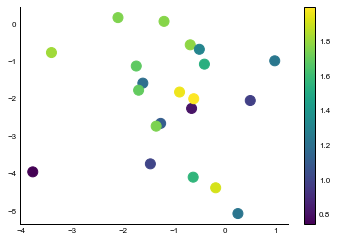

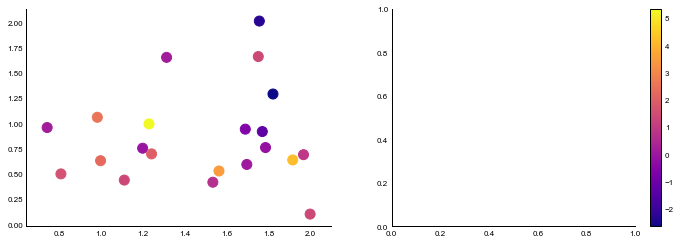

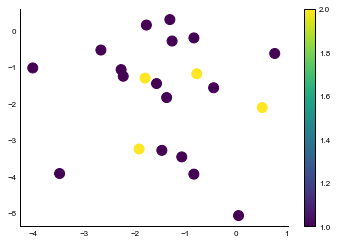

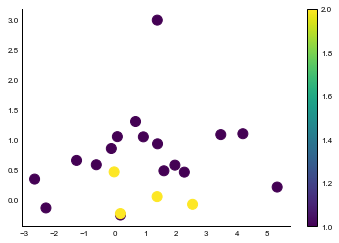

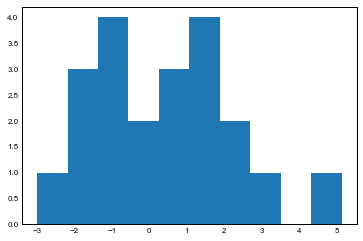

0.47619047619


In [194]:
fig, ax = plt.subplots()
cbar = ax.scatter(np.log(g_var), np.log(o_var), c=g_mean, cmap=matplotlib.cm.viridis)
plt.colorbar(cbar)
simpleaxis(ax)
plt.show()

fig, (ax1,ax2) = plt.subplots(ncols=2)
cbar = ax1.scatter(g_mean, o_mean, c=np.log(g_var/o_var), cmap=matplotlib.cm.plasma)
plt.colorbar(cbar)
# cbar = ax2.scatter(g_mean, o_mean, c=np.log(o_var), cmap=matplotlib.cm.plasma)
# plt.colorbar(cbar)
ax = [ax1,ax2]
simpleaxis(ax)
fig.set_figwidth(12)
plt.show()

fig, ax = plt.subplots()
cbar = ax.scatter(np.log(g_var/g_mean), np.log(o_var/o_mean), c=num_sqr, cmap=matplotlib.cm.viridis)
plt.colorbar(cbar)
simpleaxis(ax)
plt.show()

fig, ax = plt.subplots()
cbar = ax.scatter(np.log(g_var/o_var), np.log(g_mean/o_mean), c=num_sqr, cmap=matplotlib.cm.viridis)
plt.colorbar(cbar)
simpleaxis(ax)
plt.show()

ff_ratio = (g_var/g_mean)/(o_var/o_mean)
fig, ax  = plt.subplots()
ax.hist(np.log(ff_ratio))
plt.show()


print(len(np.where(np.log(ff_ratio) <0)[0])/float(len((np.log(ff_ratio)))))

KeyError: frozenset([(1, 5)])

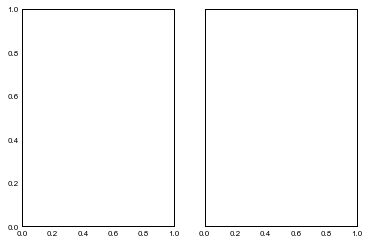

In [160]:
f, ax = plt.subplots(1,2, sharey=True)

## Control stuff
squareVal = []
list_control_expected = []
list_control_observed = []

max_exp, max_g_exp = 0.,0.
for sqr in sorted(observed):
    squareVal.append(ax[0].scatter(expected[sqr], observed[sqr], label=str(sqr), c=color_sqr[sqr], alpha=0.8, s=3))
    max_exp = max(max_exp, max(expected[sqr]))
    list_control_expected += expected[sqr]
    list_control_observed += observed[sqr]
    
X = np.array(list_control_expected)
y = np.array(list_control_observed)
idx   = np.argsort(X)
X = X[idx]
y = y[idx]

linear_Model = lmfit.Model(linearModel)
DN_Model = lmfit.Model(DN_model)

lin_pars = linear_Model.make_params()
lin_result = linear_Model.fit(y, lin_pars, x=X)
lin_aic.append(lin_result.aic)
lin_chi.append(lin_result.redchi)

DN_pars = DN_Model.make_params()
DN_result = DN_Model.fit(y, DN_pars, x=X)
dn_aic.append(DN_result.aic)
dn_chi.append(DN_result.redchi)

# print (lin_result.fit_report())
# print (DN_result.fit_report())

ax[0].set_xlim(xmin=0.)
ax[0].set_ylim(ymin=0.)
ax[0].set_xlabel("Expected")
ax[0].set_ylabel("Observed")
ax[0].set_title("Divisive Normalization fits")
div_norm = ax[0].plot(X, DN_result.best_fit, '-')


max_exp *=1.1
max_g_exp *=1.1
ax[0].set_xlim(0,max_exp)
ax[0].set_ylim(0,max_exp)
ax[0].set_xlabel("Expected Sum (mV)")
ax[0].set_ylabel("Observed Sum (mV)")
linear = ax[0].plot((0,max_exp), (0,max_exp), '--', c='gray')

legends = div_norm
#labels = [ "$\\beta={:.2f}$ \n $ \\gamma={:.2f}$".format(DN_result.params['beta'].value, DN_result.params['gamma'].value)]
labels = [ "$ \\gamma={:.2f}$".format(DN_result.params['gamma'].value)]
ax[0].legend(legends, labels)


### GABAzine stuff 
squareVal = []
list_gabazine_expected = []
list_gabazine_observed = []

max_exp, max_g_exp = 0.,0.
for sqr in sorted(g_observed):
    squareVal.append(ax[1].scatter(g_expected[sqr], g_observed[sqr], label=str(sqr), c=color_sqr[sqr], alpha=0.8, s=3))
    max_exp = max(max_exp, max(g_expected[sqr]))
    list_gabazine_expected += g_expected[sqr]
    list_gabazine_observed += g_observed[sqr]
    
X = np.array(list_gabazine_expected)
y = np.array(list_gabazine_observed)
idx   = np.argsort(X)
X = X[idx]
y = y[idx]

linear_Model = lmfit.Model(linearModel)
DN_Model = lmfit.Model(DN_model)

lin_pars = linear_Model.make_params()
lin_result = linear_Model.fit(y, lin_pars, x=X)
lin_aic.append(lin_result.aic)
lin_chi.append(lin_result.redchi)

DN_pars = DN_Model.make_params()
DN_result = DN_Model.fit(y, DN_pars, x=X)
dn_aic.append(DN_result.aic)
dn_chi.append(DN_result.redchi)

# print (lin_result.fit_report())
# print (DN_result.fit_report())

ax[1].set_xlim(xmin=0.)
ax[1].set_ylim(ymin=0.)
ax[1].set_title("Divisive Normalization fits")
div_norm = ax[1].plot(X, DN_result.best_fit, '-')


max_exp *=1.1
max_g_exp *=1.1
ax[1].set_xlim(0,max_exp)
ax[1].set_ylim(0,max_exp)
ax[1].set_xlabel("Expected Sum (mV)")
# ax[1].set_ylabel("Observed Sum (mV)")
linear = ax[1].plot((0,max_exp), (0,max_exp), '--', c='gray')

legends = div_norm
#labels = [ "$\\beta={:.2f}$ \n $\\gamma={:.2f}$".format(DN_result.params['beta'].value, DN_result.params['gamma'].value)]
labels = [ "$\\gamma={:.2f}$".format(DN_result.params['gamma'].value)]
ax[1].legend(legends, labels)
ax[1].yaxis.set_visible(False)
simpleaxis(ax)
f.set_figwidth(3)
f.set_figheight(1.5)
dump(f,file('figures/fig5/5a.pkl','wb'))
plt.show()

## 5 C Gabazine - Control responses are still balanced

In [ ]:
feature = 0
#expected, observed, g_expected, g_observed = {}, {}, {}, {}
control, gabazine = {}, {}
for expType, exp in neuron:
    ## Control case
    if(expType == "Control"):
        for sqr in exp:
            if sqr > 1:
                expected[sqr] = []
                observed[sqr] = []
                for coord in exp[sqr].coordwise:
                    if all([value == 0 for value in exp[sqr].coordwise[coord].flags.values()]):
                        control[sqr] = exp[sqr]
    ## Gabazine case
    if(expType == "GABAzine"):
        for sqr in exp:
            if sqr > 1:
                g_expected[sqr] = []
                g_observed[sqr] = []
                for coord in exp[sqr].coordwise:
                    if all([value == 0 for value in exp[sqr].coordwise[coord].flags.values()]):
                        gabazine[sqr] = exp[sqr]

derived_inh, exc = {}, {}
for sq in set(control).intersection(set(gabazine)):
    derived_inh[sq] = []
    exc[sq] = []
    for coord in set(control[sq].coordwise).intersection(set(gabazine[sq].coordwise)):
        derived_inh[sq].append(gabazine[sq].coordwise[coord].average_feature[feature] - control[sq].coordwise[coord].average_feature[feature])
        exc[sq].append(gabazine[sq].coordwise[coord].average_feature[feature])
### Derived Inh
squareVal = []
list_exc = []
list_inh = []
f, ax = plt.subplots()
max_exp, max_g_exp = 0.,0.
for sqr in sorted(derived_inh):
    squareVal.append(ax.scatter(exc[sqr], derived_inh[sqr], label=str(sqr), c=color_sqr[sqr], s=5))
    max_exp = max(max_exp, max(exc[sqr]))
    list_exc += exc[sqr]
    list_inh += derived_inh[sqr]
    
max_exp *=1.1
max_g_exp *=1.1
ax.set_xlim(0,max_exp)
ax.set_ylim(0,max_exp)
ax.set_xlabel("Excitation (mV)")
ax.set_ylabel("Derived Inhibition (mV)")
linear = ax.plot((0,max_exp), (0,max_exp), '--', c='gray')

legends = squareVal + linear
labels = sorted(observed.keys()) + [ "Linear sum"]

slope, intercept, rval, pval, stderr = ss.linregress(list_exc, list_inh)
x_ = np.linspace(0,max_exp)
y_ = (slope*x_) + intercept
ax.plot(x_,y_, '--', color='gray')
print slope, rval**2, intercept
x_intercept = -intercept/slope
print x_intercept
# ax.legend(legends, labels)

f.set_figwidth(2)
f.set_figheight(2)
simpleaxis(ax)
plt.show()